# Measure spectra from PSFs

The PSF wings are wavelength-dependent: in any finite-aperture system, there's always a sharp edge somewhere that functions as a grating.  We can use that within the narrow-band filters because the orders don't overlap.

The idea below is to try to fit spectra to real photometry data.

I'm specifically looking for the spectral shape of the F466N band to see whether the PSFs are more consistent with blue-peaked or non-blue-peaked sources.  The CO ice line should completely block the red end and should shift the effective wavelength to the blue end.

First pass is actual fitting, which seems not to be super successful.

Next thing to try is just "does a red or blue PSF fit better?"

In [1]:
from astropy.table import Table
import pylab as pl
basepath = '/orange/adamginsburg/jwst/brick/'
basetable_merged1182_daophot = Table.read(f'{basepath}/catalogs/basic_merged_indivexp_photometry_tables_merged.fits')

In [2]:
f410m466 = basetable_merged1182_daophot['mag_ab_f410m'] - basetable_merged1182_daophot['mag_ab_f466n']

In [3]:
ok = (basetable_merged1182_daophot['qfit_f466n'] < 0.3) & (basetable_merged1182_daophot['qfit_f410m'] < 0.3)
blue = basetable_merged1182_daophot[(f410m466 < -1) & ok]
blue.sort('mag_ab_f466n')
blue['skycoord_ref', 'mag_ab_f466n', 'mag_ab_f410m']

skycoord_ref,mag_ab_f466n,mag_ab_f410m
"deg,deg",,
SkyCoord,float64,float64
"266.54688955811974,-28.69230381061348",12.705780902672007,11.66514272326646
"266.539888985834,-28.672401686278334",12.925799210518125,11.87984106296745
"266.52609752658884,-28.680227100102844",12.952991101465713,11.935640274688353
"266.5530823598822,-28.684080160600807",13.17266222366264,11.934582244229654
"266.5324266154619,-28.678267117640402",13.23562783326234,12.141668201261366
"266.54931286019917,-28.695826993859303",13.335270790523609,12.20666617001784
"266.534744110837,-28.735517832351793",13.35887705117267,12.355994036327449
"266.55390999413896,-28.761255793419686",13.409284165476263,12.20602532824029


In [4]:
import regions
from astropy import units as u

In [5]:
from astropy.io import fits
from astropy.wcs import WCS
from jwst import datamodels

In [6]:
from astropy.visualization import simple_norm

2025-03-29 21:45:26,385 - stpipe - WARNING - /orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.540170 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.675374 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526575779.684 from OBSGEO-[XYZ]'.
  warnings.warn(



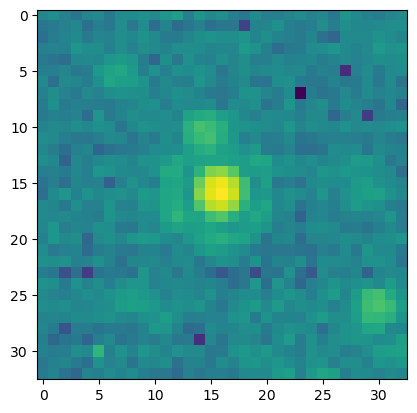

In [7]:
fh = fits.open('/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221001001_05101_00017_nrcblong_destreak_o001_crf.fits')
reg = regions.RectangleSkyRegion(center=blue['skycoord_ref'][11], width=2*u.arcsec, height=2*u.arcsec)
ww = WCS(fh['SCI'].header)
mask = reg.to_pixel(ww).to_mask()
cutout = mask.cutout(fh['SCI'].data)
pl.imshow(cutout, norm=simple_norm(cutout, stretch='log'))

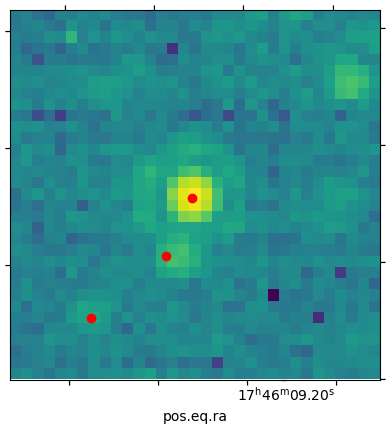

In [8]:
slc, _ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=(ww.celestial[slc]))
pl.imshow(cutout, norm=simple_norm(cutout, stretch='log'))
axlims = ax.axis()
ax.scatter_coord(blue['skycoord_ref'], c='r')
#ax.scatter_coord(basetable_merged1182_daophot['skycoord_ref'], c='g')
ax.axis(axlims);

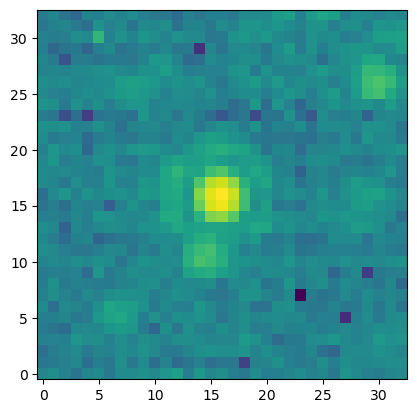

In [9]:
pl.imshow(cutout, norm=simple_norm(cutout, stretch='log'), origin='lower')

In [10]:
import numpy as np
import stpsf
import pylab as pl

## Load PSF

In [11]:
nc = stpsf.NIRCam()
nc.filter='F466N'
nc.detector='NRCA5'
#m.pupilopd = 'OPD_RevW_ote_for_MIRI_requirements.fits.gz'       # select an OPD
                                            # looks inside $STPSF_DATA/MIRI/OPD by default
                                             # or you can specify a full path name.
nc.options['parity'] = 'odd'                 # please make an output PSF with its center
                                             # aligned to the center of a single pixel

nwavelength = 11
waves = np.linspace(4.6, 4.70, nwavelength)
waves_m = waves*1e-6     # iterate over wavelengths in meters
pl.figure(dpi=200)
psfs = {}
for iw, wavelength in enumerate(waves_m):
    psfs[wavelength] = grid = nc.psf_grid(num_psfs=9, monochromatic=wavelength,
                                          fov_arcsec=30, oversample=4,
                                          all_detectors=False, verbose=False)
    # psffile = 'psf_NIRCam466_mono_%.2fum_opd1.fits' % (wavelength*1e6)
    # psf = nc.calc_psf(fov_arcsec=30, oversample=4, monochromatic=wavelength, display=False,
    #            outfile=psffile)
    # ax = pl.subplot(4,4,iw+1)
    # stpsf.display_psf(psffile, ext='DET_SAMP', colorbar=False, imagecrop=8)
    # ax.set_title('')
    # ax.xaxis.set_visible(False)
    # ax.yaxis.set_visible(False)
    # ax.text(-3.5, 0, '{0:.1f}'.format(wavelength*1e6))

2025-03-29 21:45:35,761 - stpipe - WARNING - /orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/stpsf/utils.py:241: UserWarning: Environment variable $STPSF_PATH is not set!

 ***********  ERROR  ******  ERROR  ******  ERROR  ******  ERROR  ***********
 *                                                                          *
 *  STPSF requires several data files to operate.                         *
 *  These files could not be located automatically at this time, or this    *
 *  version of the software requires a newer set of reference files than    *
 *  you have installed.  For more details see:                              *
 *                                                                          *
 *        https://stpsf.readthedocs.io/en/stable/installation.html        *
 *                                                                          *
 *  under "Installing the Required Data Files".                             *
 *  STPSF will not be ab

<Figure size 1280x960 with 0 Axes>

In [12]:
from astropy.modeling.fitting import LevMarLSQFitter, LMLSQFitter
from astropy.modeling import Model
from astropy.modeling.models import custom_model
lmfitter = LevMarLSQFitter()
lmlsqfitter = LMLSQFitter()
import stpsf
from stpsf.utils import to_griddedpsfmodel

## Create model

The model is just a centroid plus a number of scaling factors to apply to each wavelength's PSF

In [13]:
yy, xx = np.mgrid[:cutout.shape[0], :cutout.shape[1]]

@custom_model
def model(xx, yy, xc=10, yc=10, a1=1, a2=1, a3=1, a4=1, a5=1, a6=1, a7=1, a8=1, a9=1, a10=1, a11=1):#, a12=1, a13=1, a14=1, a15=1, a16=1):
    rslt = np.zeros_like(cutout)
    args = [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11,]# a12, a13, a14, a15, a16]
    # cannot have negatives.
    args = [np.abs(arg) for arg in args]
    npars = len(args)
    for amp, (wav, pp) in zip(args, psfs.items()):
        modslc = pp.evaluate(xx, yy, amp, xc, yc)
        rslt += modslc/modslc.max() * amp
    #rslt /= npars
    return rslt
model, model()

(<class 'astropy.modeling.core.model'>
Name: model
N_inputs: 2
N_outputs: 1
Fittable parameters: ('xc', 'yc', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11'),
 <model(xc=10., yc=10., a1=1., a2=1., a3=1., a4=1., a5=1., a6=1., a7=1., a8=1., a9=1., a10=1., a11=1.)>)

In [14]:
waves

array([4.6 , 4.61, 4.62, 4.63, 4.64, 4.65, 4.66, 4.67, 4.68, 4.69, 4.7 ])

<model(xc=1511.5, yc=1089.5, a1=1., a2=1., a3=1., a4=1., a5=1., a6=1., a7=1., a8=1., a9=1., a10=1., a11=1.)>

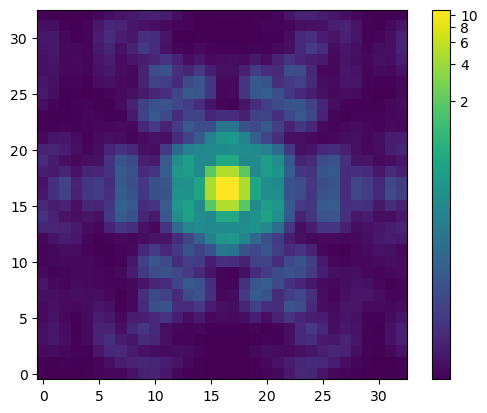

In [15]:
slc, _ = mask.get_overlap_slices(fh['SCI'].data.shape)
xstart, ystart = slc[1].start, slc[0].start
xmid = (xstart + slc[1].stop)/2
ymid = (ystart + slc[0].stop)/2
mod_init = model(xmid, ymid)
mod = mod_init(xx+xstart, yy+ystart)
pl.imshow(mod, norm=simple_norm(mod, stretch='log'), origin='lower')
pl.colorbar()
mod_init

In [16]:
for parname in mod_init.param_names:
    if parname.startswith('a'):
        getattr(mod_init, parname).bounds = (1/25., 1/4.)
        getattr(mod_init, parname).value = 1/16. + np.random.randn() * 1/128.
        
#fitted = lmfitter(mod_init, xx+xstart, yy+ystart, cutout/cutout.max(), acc=1e-9, maxiter=1500)
fitted = LMLSQFitter()(mod_init, xx+xstart, yy+ystart, cutout/cutout.max(), acc=1e-9, maxiter=1500)
fitted, lmfitter.fit_info['nfev']

(<model(xc=1510.88735544, yc=1088.86538594, a1=0.04, a2=0.25, a3=0.25, a4=0.04, a5=0.04, a6=0.25, a7=0.04, a8=0.04, a9=0.25, a10=0.25, a11=0.04)>,
 None)

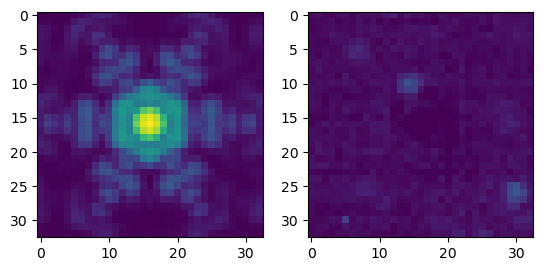

In [17]:
fittedim = fitted(xx+xstart, yy+ystart)
pl.subplot(1,2,1)
pl.imshow(fittedim, norm=simple_norm(fittedim, stretch='log'))
pl.subplot(1,2,2)
pl.imshow(cutout/cutout.max() - fittedim, norm=simple_norm(fittedim, stretch='asinh'))

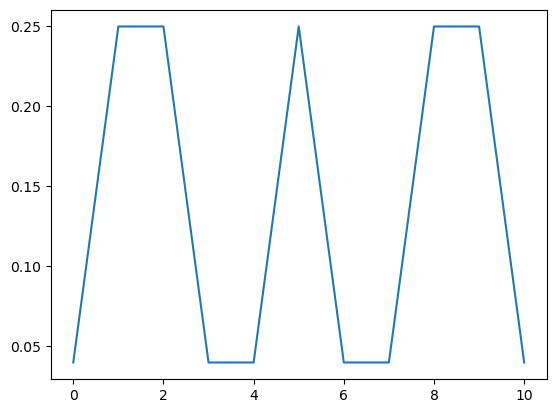

In [18]:
pl.plot(fitted.parameters[2:])

In [19]:
from astroquery.svo_fps import SvoFps
instrument = 'NIRCam'
telescope = 'JWST'
filt466 = 'F466N'
wavelength_table_466 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt466}')

Set OBSGEO-B to   -20.675374 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526575779.684 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2025-03-29 21:50:41,173 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.540170 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.675374 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526575779.684 from OBSGEO-[XYZ]'.


0.0004942663190320072 0.0026200604444440163 (0.01, 0.5)
0.0018203679701840872 0.009624491111108947 (0.01, 0.5)
0.007953256866576868 0.04486237999999373 (0.01, 0.5)
0.03899180649001195 0.18991145185183897 (0.01, 0.5)
0.05974380813015651 0.32143962962962447 (0.01, 0.5)
0.05971420511509754 0.3255178370370367 (0.01, 0.5)
0.06124909148111531 0.3284242592592597 (0.01, 0.5)
0.06524633383000997 0.3155511777777812 (0.01, 0.5)
0.032041990658884384 0.1822674926470863 (0.01, 0.5)
0.0063876241179215846 0.034320175555555124 (0.01, 0.5)
0.0011974174129860792 0.006006910666667478 (0.01, 0.5)
Model: model
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
      xc     yc  ...          a10                   a11         
    ------ ----- ... --------------------- ---------------------
    1685.5 876.5 ... 0.0063876241179215846 0.0011974174129860792
Model: model
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
      xc     yc  ...          a10                   a11         
 

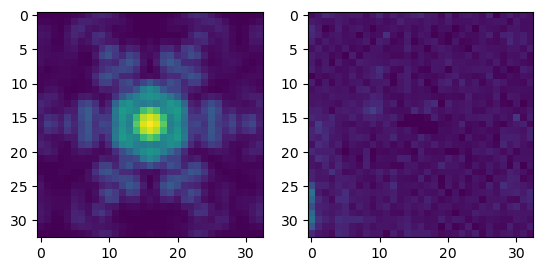

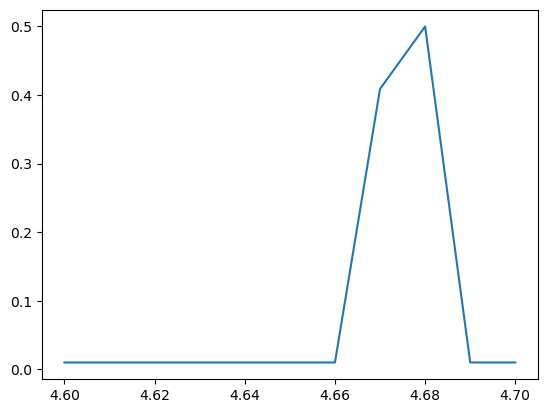

In [20]:
fh = fits.open('/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221001001_05101_00017_nrcblong_destreak_o001_crf.fits')
reg = regions.RectangleSkyRegion(center=blue['skycoord_ref'][15], width=2*u.arcsec, height=2*u.arcsec)
ww = WCS(fh['SCI'].header)
mask = reg.to_pixel(ww).to_mask()
cutout = mask.cutout(fh['SCI'].data)


slc, _ = mask.get_overlap_slices(fh['SCI'].data.shape)
xstart, ystart = slc[1].start, slc[0].start
xmid = (xstart + slc[1].stop)/2
ymid = (ystart + slc[0].stop)/2
mod_init = model(xmid, ymid)
mod = mod_init(xx+xstart, yy+ystart)

trans = np.interp(waves, wavelength_table_466['Wavelength'].quantity.to(u.um).value, wavelength_table_466['Transmission'].value)
for trn, parname in zip(trans, mod_init.param_names[2:]):
    if parname.startswith('a'):
        getattr(mod_init, parname).bounds = (0.01, 1/2.)
        getattr(mod_init, parname).value = (3/16. + np.random.randn() * 1/128.) * trn
        print(getattr(mod_init, parname).value, trn, getattr(mod_init, parname).bounds)
print(mod_init)
mod_init.xc.bounds = (xmid-2, xmid+2)
mod_init.yc.bounds = (ymid-2, ymid+2)
        
#fitted = lmfitter(mod_init, xx+xstart, yy+ystart, cutout/cutout.max(), acc=1e-9, maxiter=1500)
fitter = LMLSQFitter()
fitter = LevMarLSQFitter()
fitted = fitter(mod_init, xx+xstart, yy+ystart, cutout/cutout.max(), maxiter=1500, acc=1e-6)#, epsilon=1e-12, maxiter=1500)

fittedim = fitted(xx+xstart, yy+ystart)
pl.subplot(1,2,1)
pl.imshow(fittedim, norm=simple_norm(fittedim, stretch='log'))
pl.subplot(1,2,2)
pl.imshow(cutout/cutout.max() - fittedim, norm=simple_norm(fittedim, stretch='asinh'))

pl.figure()
pl.plot(waves, np.abs(fitted.parameters[2:]), )# yerr=fitter.fit_info['param_cov'].diagonal()[2:]**0.5)
# pl.errorbar(np.linspace(4.6, 4.75, 16), np.abs(fitted.parameters[2:]), yerr=fitter.fit_info['param_cov'].diagonal()[2:]**0.5)

print(mod_init, fitted, '\nnfev: ', lmfitter.fit_info['nfev'])

In [21]:
fitter.fit_info

{'nfev': 75,
 'fvec': array([-0.0079803 , -0.01702291, -0.03362799, ..., -0.01084889,
        -0.0193613 , -0.00771487]),
 'fjac': array([[-1.98453575e+00,  1.53869380e-05,  1.97202523e-05, ...,
          2.46411346e-05,  7.51903475e-06,  1.25225438e-05],
        [-7.61980625e-02,  1.33300812e+00,  2.47930894e-06, ...,
         -4.03250900e-05, -1.08186180e-05,  1.25231252e-05],
        [ 1.16170532e-02, -4.66671039e-03,  1.28592847e+00, ...,
          3.64192051e-05, -1.49945672e-05, -1.50128196e-05],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 'ipvt': array([10,  1,  2,  4,  5,  6,  7,  8,  9,  3, 11, 12, 13], dtype=int32),
 'qtf': array([ 

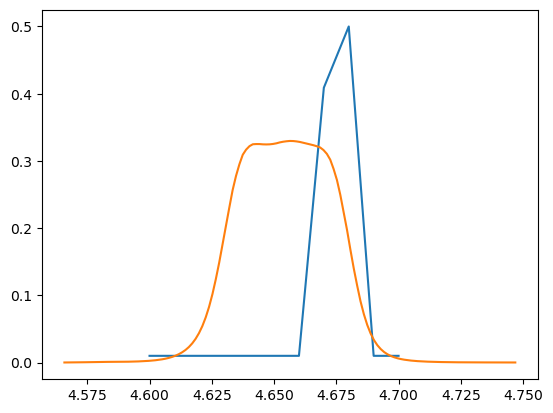

In [22]:
pl.plot(waves, fitted.parameters[2:])
pl.plot(wavelength_table_466['Wavelength'].to(u.um), wavelength_table_466['Transmission'])

## Attempt annealing.  It's slow

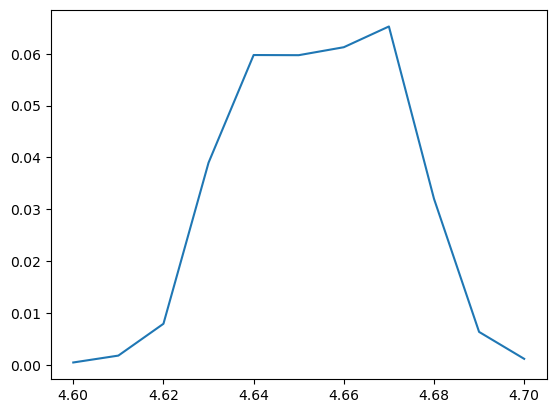

In [23]:
pl.plot(waves, np.abs(mod_init.parameters[2:]))

## How many PSFs do I have to work with?

In [24]:
import glob

In [25]:
fh.info()

Filename: /orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221001001_05101_00017_nrcblong_destreak_o001_crf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     362   ()      
  1  SCI           1 ImageHDU       127   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [40543B]   


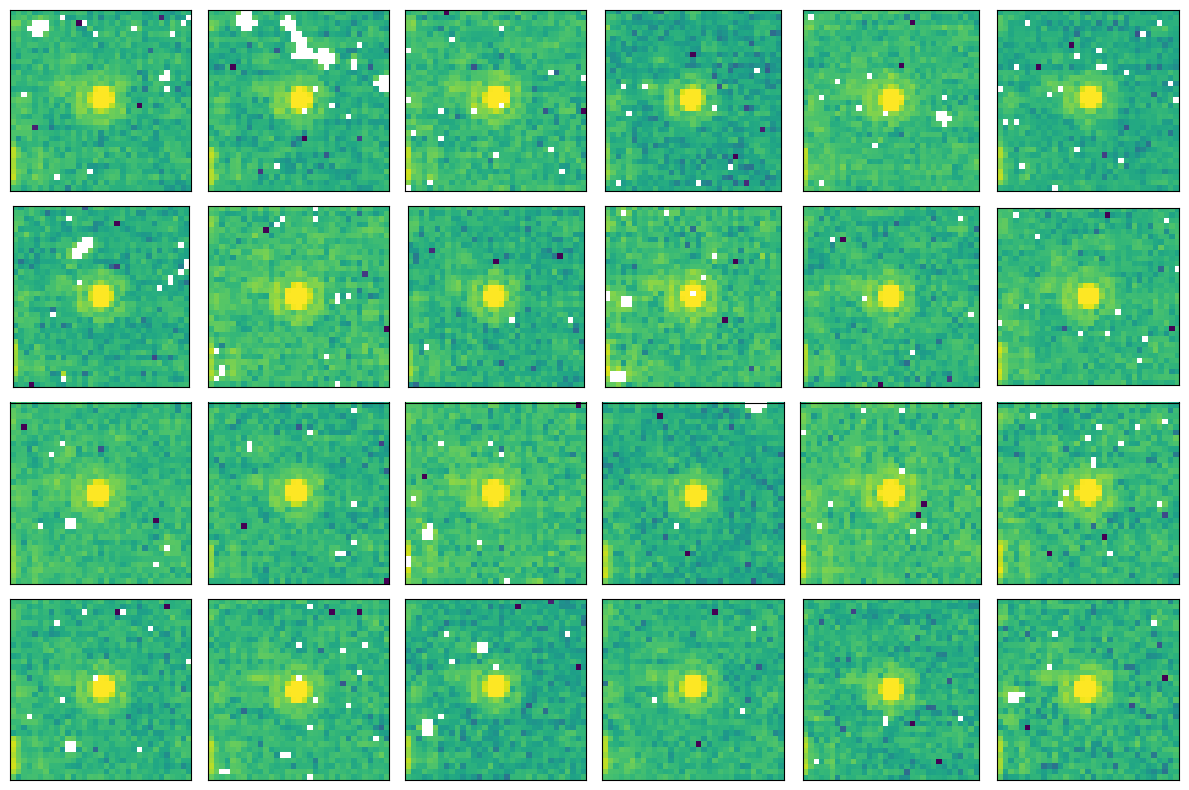

In [31]:
pl.figure(figsize=(12, 8))
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for expnum in range(1,25):
        fh = fits.open(f'/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221001001_05101_000{expnum:02d}_nrcblong_destreak_o001_crf.fits')
        reg = regions.RectangleSkyRegion(center=blue['skycoord_ref'][15], width=2*u.arcsec, height=2*u.arcsec)
        ww = WCS(fh['SCI'].header)
        mask = reg.to_pixel(ww).to_mask()
        cutout = mask.cutout(fh['SCI'].data)
        dq_cutout = mask.cutout(fh['DQ'].data)
        cutout[dq_cutout > 0] = np.nan
        #print(expnum, cutout is None)
        ax = pl.subplot(4, 6, expnum)
        ax.imshow(cutout, norm=simple_norm(cutout, min_percent=0.1, max_percent=99, stretch='log'))
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
    pl.tight_layout();

# nueff fit

In [32]:
@custom_model
def model_nueff(xx, yy, xc=10, yc=10, amp=1, nueff=4.650):
    rslt = np.zeros_like(cutout)

    ind1 = np.argmin(np.abs(waves-nueff))
    w1 = waves[ind1]
    ind2 = ind1-1  if nueff < w1 else ind1+1
    if ind2 >= len(waves):
        ind2 = len(waves) - 1
        ind1 = ind2 - 1
    elif ind2 < 0:
        ind2 = 1
        ind1 = 0
    assert ind1 != ind2, f"ind1={ind1}, ind2={ind2}"
    w1 = waves[ind1]
    w2 = waves[ind2]
    if w1 > w2:
        w1, w2 = w2, w1
    assert w2 > w1
    keys = list(psfs.keys())
    psf = amp * (psfs[keys[ind1]].evaluate(xx, yy, (nueff - w1), xc, yc) + psfs[keys[ind2]].evaluate(xx, yy, (w2 - nueff), xc, yc)) / (w2 - w1)
    
    return psf
model_nueff, model_nueff()

(<class 'astropy.modeling.core.model_nueff'>
Name: model_nueff
N_inputs: 2
N_outputs: 1
Fittable parameters: ('xc', 'yc', 'amp', 'nueff'),
 <model_nueff(xc=10., yc=10., amp=1., nueff=4.65)>)

Set OBSGEO-B to   -20.675374 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526575779.684 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2025-03-29 21:53:29,622 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.540170 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.675374 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526575779.684 from OBSGEO-[XYZ]'.


Model: model_nueff
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
      xc     yc  amp nueff
    ------ ----- --- -----
    1685.5 876.5 1.0  4.65 Model: model_nueff
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
            xc                 yc               amp         nueff
    ------------------ ----------------- ------------------ -----
    1685.0038981051666 875.9713670988684 10.728253730299869   4.7 
nfev:  None


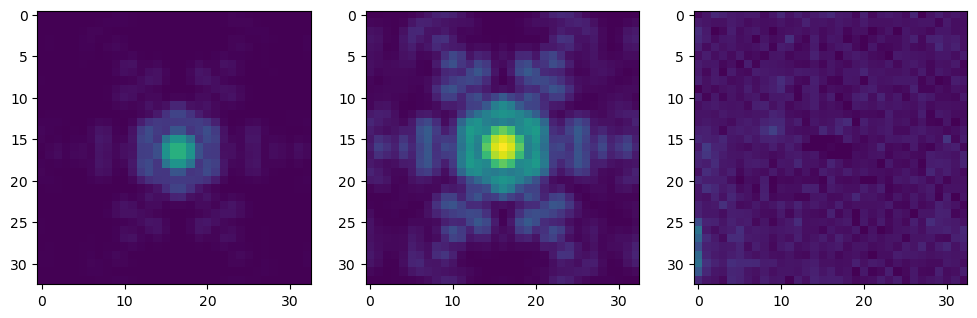

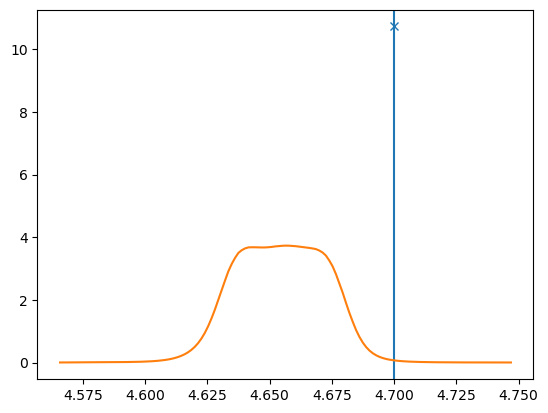

In [35]:
fh = fits.open('/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221001001_05101_00017_nrcblong_destreak_o001_crf.fits')
reg = regions.RectangleSkyRegion(center=blue['skycoord_ref'][15], width=2*u.arcsec, height=2*u.arcsec)
ww = WCS(fh['SCI'].header)
mask = reg.to_pixel(ww).to_mask()
cutout = mask.cutout(fh['SCI'].data)

# Set up initial model and region
slc, _ = mask.get_overlap_slices(fh['SCI'].data.shape)
xstart, ystart = slc[1].start, slc[0].start
xmid = (xstart + slc[1].stop)/2
ymid = (ystart + slc[0].stop)/2
mod_init = model_nueff(xc=xmid, yc=ymid)
mod = mod_init(xx + xstart, yy + ystart)

mod_init.nueff.bounds = (waves.min(), waves.max())
mod_init.xc.bounds = (xmid-2, xmid+2)
mod_init.yc.bounds = (ymid-2, ymid+2)

pl.figure(figsize=(12,5));
pl.subplot(1,3,1).imshow(mod_init( xx+xstart, yy+ystart),  norm=simple_norm(fittedim, stretch='log'))

#fitted = lmfitter(mod_init, xx+xstart, yy+ystart, cutout/cutout.max(), acc=1e-9, maxiter=1500)
fitter = LMLSQFitter()
#fitter = LevMarLSQFitter()
fitted = fitter(mod_init, xx+xstart, yy+ystart, cutout/cutout.max(), )


fittedim = fitted(xx+xstart, yy+ystart)
pl.subplot(1,3,2)
pl.imshow(fittedim, norm=simple_norm(fittedim, stretch='log'))
pl.subplot(1,3,3)
pl.imshow(cutout/cutout.max() - fittedim, norm=simple_norm(fittedim, stretch='asinh'))

pl.figure()
#pl.plot(waves, np.abs(fitted.parameters[2:]), )# yerr=fitter.fit_info['param_cov'].diagonal()[2:]**0.5)
pl.axvline(fitted.parameters[3])
pl.plot(fitted.parameters[3], fitted.parameters[2], 'x')
pl.plot(wavelength_table_466['Wavelength'].to(u.um), wavelength_table_466['Transmission'] * pl.ylim()[-1])
# pl.errorbar(np.linspace(4.6, 4.75, 16), np.abs(fitted.parameters[2:]), yerr=fitter.fit_info['param_cov'].diagonal()[2:]**0.5)

print(mod_init, fitted, '\nnfev: ', lmfitter.fit_info['nfev'])

1044.0 11943.402 [913.15429647 877.66487511  11.48479537   4.6       ] 398.5074 1.0516183184690293
1011.0 11989.205 [946.28816374 856.8216313   11.17333736   4.6       ] 407.45776 1.0307161225639097
1052.0 11846.385 [934.05721154 910.65325354  11.51188673   4.6       ] 397.48843 1.0598576957489119
1097.0 11863.737 [963.70015126 891.29582803  11.62059552   4.6       ] 399.11646 1.0437651324295676
1086.0 11996.86 [ 910.10168747 1048.36723082   11.21122443    4.6       ] 405.21387 1.0235956943833475
1048.0 12524.131 [ 943.33200346 1027.52173998   12.12389412    4.6       ] 379.1721 1.0305045441326013
1082.0 12080.927 [ 931.04513551 1081.43850937   11.50348953    4.6       ] 394.99445 1.030964744730774
1058.0 11885.569 [ 960.78246711 1062.06455856   10.77747224    4.6       ] 429.6411 1.0186643951479515
1099.0 12484.238 [1296.74294552 1048.52364217   11.8824178     4.6       ] 384.83267 1.023985911679304
1086.0 12067.829 [1329.95471728 1027.40170342   12.63449098    4.6       ] 370.51624 1

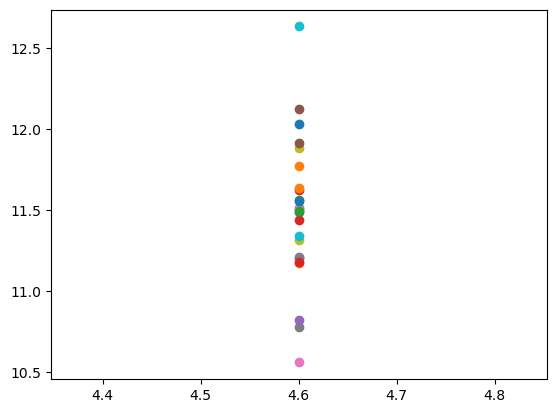

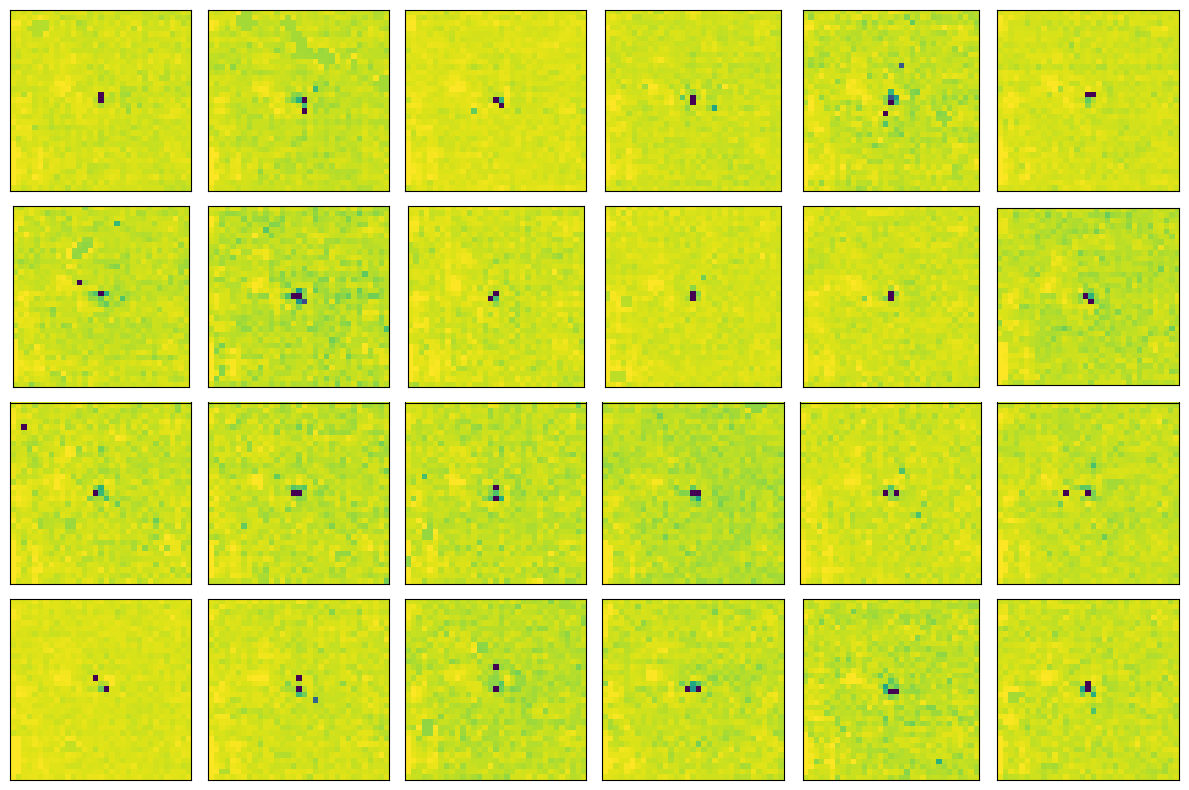

In [47]:
warnings.simplefilter('ignore')
pl.figure(1, figsize=(12, 8))
for expnum in range(1,25):
    fh = fits.open(f'/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221001001_05101_000{expnum:02d}_nrcblong_destreak_o001_crf.fits')
    reg = regions.RectangleSkyRegion(center=blue['skycoord_ref'][15], width=2*u.arcsec, height=2*u.arcsec)
    ww = WCS(fh['SCI'].header)
    mask = reg.to_pixel(ww).to_mask()
    cutout = mask.cutout(fh['SCI'].data)
    dq_cutout = mask.cutout(fh['DQ'].data)
    #cutout[dq_cutout > 0] = np.nan
    weights = np.ones_like(cutout)
    weights[np.isnan(cutout) | (dq_cutout > 0)] = 0
    cutout[weights == 0] = 0
    
    slc, _ = mask.get_overlap_slices(fh['SCI'].data.shape)
    xstart, ystart = slc[1].start, slc[0].start
    xmid = (xstart + slc[1].stop)/2
    ymid = (ystart + slc[0].stop)/2
    mod_init = model_nueff(xc=xmid, yc=ymid, amp=5,)
    mod = mod_init(xx + xstart, yy + ystart)
    
    mod_init.nueff.bounds = (waves.min(), waves.max())
    mod_init.xc.bounds = (xmid-2, xmid+2)
    mod_init.yc.bounds = (ymid-2, ymid+2)

    yy, xx = np.mgrid[:cutout.shape[0], :cutout.shape[1]]

    fitter = LevMarLSQFitter()
    fitted = fitter(mod_init, x=xx+xstart, y=yy+ystart, z=cutout/cutout.max(), weights=weights)
    weights[cutout/cutout.max() > 0.1] = 0
    pl.figure(2)
    pl.plot(fitted.parameters[3], fitted.parameters[2], 'o')

    pl.figure(1)
    ax = pl.subplot(4, 6, expnum)
    modelimage = fitted(xx+xstart, yy+ystart)
    resid = cutout/cutout.max() - modelimage
    print(weights.sum(), cutout.sum(), fitted.parameters, np.nanmax(cutout), modelimage.max())
    ax.imshow(resid, norm=simple_norm(resid, min_percent=0.1, max_percent=99, stretch='log'))
    #ax.imshow(modelimage, norm=simple_norm(modelimage, min_percent=0.1, max_percent=99, stretch='log'))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
pl.tight_layout();


# Mask the fit based on maximum difference

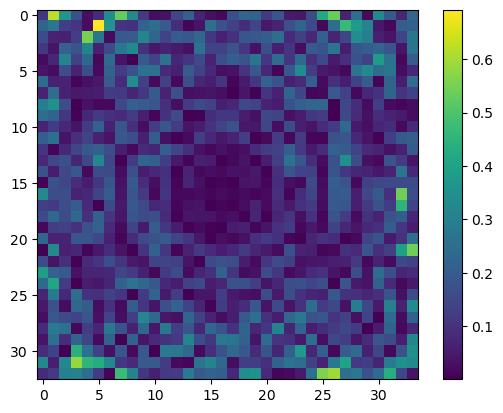

In [43]:
modlo = model_nueff(xc=16, yc=16, nueff=4.62)(xx, yy)
modhi = model_nueff(xc=16, yc=16, nueff=4.68)(xx, yy)
diff = modlo-modhi
fracdiff = np.abs(diff/modlo)
pl.imshow(fracdiff);
pl.colorbar();